In [ ]:
  # @staticmethod
  # def gen_random(nstates=4, min_terminals=1, ntransitions=4):

  #   if min_terminals > nstates:
  #     raise Exception("nterminals > nstates")

  #   # Let's generate a bunch of states
  #   states = [FSM() for _ in range(nstates)]
  #   start = states[0]

  #   # Add random transitions
  #   prev_state = start
  #   cnt_inputs = 0
  #   for _ in range(ntransitions):
  #     next_state = random.choice(states)
  #     # Shall we create a new input or reuse an old one
  #     if random.choice([True,False]):
  #       val = cnt_inputs
  #       cnt_inputs += 1
  #     else:
  #       val = random.randint(0,cnt_inputs+1)

  #     prev_state.add_transition(val, [next_state])
  #     prev_state = next_state

  #   # Let's check how many terminal states we have already
  #   count_terminals = 0
  #   for state in states:
  #     if state.is_final():
  #       count_terminals += 1

  #   # Let's add as many terminal states as needed to reach min_terminal
  #   while count_terminals < min_terminals:
  #     state = random.choice(states)
  #     if not state.is_final():
  #       state.set_final(True)
  #       count_terminals += 1

  #   # There is a risk we never terminate, let's prevent that
  #   while len(list(start.bfs(max=1, max_depth=ntransitions))) == 0:
  #     random.choice(states).set_final(True)

  #   return start



#def max_pad(exprs, val=0):
#  exprs = list(exprs)
#  max_len = len(max(exprs, key = lambda x: len(x)))
#
#  for expr in exprs:
#    expr.extend([val]*(max_len-len(expr)))
#  return exprs


In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import string
import random
from typing import Dict, List, Optional, Generator, Tuple
from collections import deque
import functools

# Part 1 - Defining Languages

Our goal is to escalete Chomsky hierarchy of language and see which model
performs best (i.e. speed, precision, etc.) at learning which language.

As a first step we create few Machine classes. Each Machine represent a class of languages and provide a `gen` and `parse` method to respectively generate expressions and parse to check their well-formedness.

The FSM (Finite State Machine) class is used to describe regular languages and generate samples.

In [ ]:
class Machine:
  def gen(self, max_samples: Optional[int] = None, max_length: Optional[int] = None) -> Generator[List[int], None, None]:
    """
    Generates up to max_samples well formed expressions beloging to the underlying
    language.

    max_samples: max number of samples to generate. Note that this value is an
      upper limit and there is no lower limit on the number of expressions
      generated (i.e. the machine might generate from 0 to max_samples expressions)
      If None generate as many expressions as possible (potentially infinite).
    max_length: max length of the expressions to be enforced, if None generate
      expressions of any length
    """
    raise NotImplementedError("Method gen not implemented")

  def parse(self, expr: List[int], stop_symbol: Optional[int] = None) -> bool:
    """
    Parse an expression and return True if it is well formed (i.e. it belongs to
    the language encoded by this Machine and it is recognized by this last)
    """
    raise NotImplementedError("Method parse not implemented")


class FSM(Machine):
  """
  A class representing a non-deterministic Finite State Machine (FSM).
  Each instance of this class in itself represent a single FSM state,
  however multiple instance linked via transitions form non-deterministic FSMs
  of arbitrary complexity.
  The FSM instance of the first state can be used as an interface to the
  whole FSM.
  """
  def __init__(self, transitions : Optional[Dict[str, List["FSM"]]] = None, is_terminal: bool = False):
    """
    Create a new state instance.

    transitions: optional dictionnary of transitions
    is_terminal: indicates whether this state must be considered terminal (note
      that a state with no transitions if already considered terminal by default)
    """
    if transitions is None:
      transitions = {}
    self.transitions = transitions;
    self._is_terminal_overwrite = is_terminal

  def set_terminal(self, is_terminal: bool = True) -> None:
    """
    If true forces this state to be considered as terminal
    """
    self._is_terminal_overwrite = is_terminal;

  def is_terminal(self) -> bool:
    """
    Returns whether this state is terminal or not
    """
    return self._is_terminal_overwrite or len(self.transitions) == 0;

  def add_transition(self, input_symbol: int, states: List["FSM"]) -> None:
    """
    Add one or more new transitions for a given input symbol.
    If there already exist transitions for that symbol, old transitions are kept.
    Note that transitions can be duplicated.

    input_symbol: an integer representing the input consumed by the FSM
    states: list of states which we can transition to given input symbol
    """
    self.transitions[input_symbol] = self.transitions.get(input_symbol, []) + states

  def traverse(self, input_symbol: int) -> List["FSM"]:
    """
    Returns the list of states we can transition to given an input symbol
    """
    return self.transitions.get(input_symbol, [])

  def rand_traverse(self) -> Tuple[int, "FSM"]:
    """
    Randomly pick a valid input symbol and a state to transition to
    """
    input_symbol = random.choice(list(self.transitions.keys()))
    next_state = random.choice(self.transitions[input_symbol])
    return (input_symbol, next_state)

  def rand_walk(self) -> Generator[int, None, None]:
    """
    Randomly generate a sequence of input symbols accepted by the FSM
    """
    state = self
    while True:
      if (not state.transitions) or (state.is_terminal() and random.randint(0,2) % 2 == 0):
        return

      input_symbol, state = state.rand_traverse()
      yield input_symbol

  def parse(self, expr: List[int], stop_symbol: Optional[int] = None) -> bool:
    """
    Parse an expression and return True if it is well formed (i.e. it belongs to
    the language encoded by the FSM and it is recognized by this last)
    """
    if len(expr) == 0 or (stop_symbol is not None and expr[0] == stop_symbol):
      return self.is_terminal()

    states = self.traverse(expr[0])
    for state in states:
      if state.parse(expr[1:], stop_symbol=stop_symbol):
        return True
    return False

  def bfs(self, max_samples: Optional[int] = None, max_depth: Optional[int] = None) -> Generator[List[int], None, None]:
    """
    Generates up to max_samples well formed expressions beloging to the underlying
    language (see gen).
    """
    # Queue of tuples (expr, state)
    queue = deque([([], self)])

    while queue:
      if max_samples is not None and max_samples <= 0:
        return

      expr, state = queue.popleft()

      if state.is_terminal():
        yield expr
        if max_samples is not None:
          max_samples -= 1

      if max_depth is not None and len(expr) >= max_depth:
        continue

      for input_, states in state.transitions.items():
        new_expr = expr + [input_]
        for new_state in states:
          queue.append((new_expr, new_state))

  def gen(self, max_samples: Optional[int] = None, max_length: Optional[int] = None) -> Generator[List[int], None, None]:
    return self.bfs(max_samples=max_samples, max_depth=max_length)


# Some testing, just to make sure everything works correctly
def test_fsm():
  s = [FSM() for _ in range(3)]
  s[0].add_transition(input_symbol=1, states=[s[0],s[1]])
  s[1].add_transition(input_symbol=2, states=[s[0],s[2]])
  s[2].add_transition(input_symbol=3, states=[s[2]])
  s[2].set_terminal(True)

  fsm = s[0]

  # Test rand traverse
  for _ in range(30):
    expr = list(fsm.rand_walk())
    if not fsm.parse(expr):
      raise Exception("rand_traverse failed: "+str(expr))

  # Test bfs
  for expr in fsm.gen(30):
    if not fsm.parse(expr):
      raise Exception("bfs failed: "+str(expr))

test_fsm()

In [ ]:

class Production(object):
  def __init__(self, *terms):
    self.terms = terms
  def __len__(self):
    return len(self.terms)
  def __getitem__(self, index):
    return self.terms[index]
  def __iter__(self):
    return iter(self.terms)
  def __repr__(self):
    return " ".join(str(t) for t in self.terms)
  def __eq__(self, other):
    if not isinstance(other, Production):
      return False
    return self.terms == other.terms
  def __ne__(self, other):
    return not (self == other)
  def __hash__(self):
    return hash(self.terms)

class Rule(object):
  def __init__(self, name, *productions):
    self.name = name
    self.productions = list(productions)
  def __str__(self):
    return self.name
  def __repr__(self):
    return "%s -> %s" % (self.name, " | ".join(repr(p) for p in self.productions))
  def add(self, *productions):
    self.productions.extend(productions)

class State(object):
  def __init__(self, name, production, dot_index, start_column):
    self.name = name
    self.production = production
    self.start_column = start_column
    self.end_column = None
    self.dot_index = dot_index
    self.rules = [t for t in production if isinstance(t, Rule)]
  def __repr__(self):
    terms = [str(p) for p in self.production]
    terms.insert(self.dot_index, u"$")
    return "%-5s -> %-16s [%s-%s]" % (self.name, " ".join(terms), self.start_column, self.end_column)
  def __eq__(self, other):
    return (self.name, self.production, self.dot_index, self.start_column) == \
      (other.name, other.production, other.dot_index, other.start_column)
  def __ne__(self, other):
    return not (self == other)
  def __hash__(self):
    return hash((self.name, self.production))
  def completed(self):
    return self.dot_index >= len(self.production)
  def next_term(self):
    if self.completed():
      return None
    return self.production[self.dot_index]

class Column(object):
  def __init__(self, index, token):
    self.index = index
    self.token = token
    self.states = []
    self._unique = set()
  def __str__(self):
    return str(self.index)
  def __len__(self):
    return len(self.states)
  def __iter__(self):
    return iter(self.states)
  def __getitem__(self, index):
    return self.states[index]
  def enumfrom(self, index):
    for i in range(index, len(self.states)):
      yield i, self.states[i]
  def add(self, state):
    if state not in self._unique:
      self._unique.add(state)
      state.end_column = self
      self.states.append(state)
      return True
    return False
  def print_(self, completedOnly = False):
    print("[%s] %r" % (self.index, self.token))
    print("=" * 35)
    for s in self.states:
      if completedOnly and not s.completed():
        continue
      print(repr(s))
    print("")

class Node(object):
  def __init__(self, value, children):
    self.value = value
    self.children = children
  def print_(self, level = 0):
    print(" " * level + str(self.value))
    for child in self.children:
      child.print_(level + 1)

def predict(col, rule):
  for prod in rule.productions:
    col.add(State(rule.name, prod, 0, col))

def scan(col, state, token):
  if token != col.token:
    return
  col.add(State(state.name, state.production, state.dot_index + 1, state.start_column))

def complete(col, state):
  if not state.completed():
    return
  for st in state.start_column:
    term = st.next_term()
    if not isinstance(term, Rule):
      continue
    if term.name == state.name:
      col.add(State(st.name, st.production, st.dot_index + 1, st.start_column))

GAMMA_RULE = u"GAMMA"

def parse(rule, text):
  table = [Column(i, tok) for i, tok in enumerate([None] + text.lower().split())]
  table[0].add(State(GAMMA_RULE, Production(rule), 0, table[0]))

  for i, col in enumerate(table):
    for state in col:
      if state.completed():
        complete(col, state)
      else:
        term = state.next_term()
        if isinstance(term, Rule):
          predict(col, term)
        elif i + 1 < len(table):
          scan(table[i+1], state, term)


  # find gamma rule in last table column (otherwise fail)
  for st in table[-1]:
    if st.name == GAMMA_RULE and st.completed():
      return st
  else:
    raise ValueError("parsing failed")

def build_trees(state):
  return build_trees_helper([], state, len(state.rules) - 1, state.end_column)

def build_trees_helper(children, state, rule_index, end_column):
  if rule_index < 0:
    return [Node(state, children)]
  elif rule_index == 0:
    start_column = state.start_column
  else:
    start_column = None

  rule = state.rules[rule_index]
  outputs = []
  for st in end_column:
    if st is state:
      break
    if st is state or not st.completed() or st.name != rule.name:
      continue
    if start_column is not None and st.start_column != start_column:
      continue
    for sub_tree in build_trees(st):
      for node in build_trees_helper([sub_tree] + children, state, rule_index - 1, st.start_column):
        outputs.append(node)
  return outputs


SYM = Rule("SYM", Production("a"))
OP = Rule("OP", Production("+"))
EXPR = Rule("EXPR", Production(SYM))
EXPR.add(Production(EXPR, OP, EXPR))

for i in range(1,9):
  text = " + ".join(["a"] * i)
  q0 = parse(EXPR, text)
  forest = build_trees(q0)
  print(len(forest), text)


N = Rule("N", Production("time"), Production("flight"), Production("banana"),
  Production("flies"), Production("boy"), Production("telescope"))
D = Rule("D", Production("the"), Production("a"), Production("an"))
V = Rule("V", Production("book"), Production("eat"), Production("sleep"), Production("saw"))
P = Rule("P", Production("with"), Production("in"), Production("on"), Production("at"),
  Production("through"))

PP = Rule("PP")
NP = Rule("NP", Production(D, N), Production("john"), Production("houston"))
NP.add(Production(NP, PP))
PP.add(Production(P, NP))

VP = Rule("VP", Production(V, NP))
VP.add(Production(VP, PP))
S = Rule("S", Production(NP, VP), Production(VP))

for tree in build_trees(parse(S, "book the flight through houston")):
  print("--------------------------")
  tree.print_()

for tree in build_trees(parse(S, "john saw the boy with the telescope")):
  print("--------------------------")
  tree.print_()

1 a
1 a + a
2 a + a + a
5 a + a + a + a
14 a + a + a + a + a
42 a + a + a + a + a + a
132 a + a + a + a + a + a + a
429 a + a + a + a + a + a + a + a
--------------------------
GAMMA -> S $              [0-5]
  S     -> VP $             [0-5]
    VP    -> VP PP $          [0-5]
      VP    -> V NP $           [0-3]
        V     -> book $           [0-1]
        NP    -> D N $            [1-3]
          D     -> the $            [1-2]
          N     -> flight $         [2-3]
      PP    -> P NP $           [3-5]
        P     -> through $        [3-4]
        NP    -> houston $        [4-5]
--------------------------
GAMMA -> S $              [0-5]
  S     -> VP $             [0-5]
    VP    -> V NP $           [0-5]
      V     -> book $           [0-1]
      NP    -> NP PP $          [1-5]
        NP    -> D N $            [1-3]
          D     -> the $            [1-2]
          N     -> flight $         [2-3]
        PP    -> P NP $           [3-5]
          P     -> through $    

Let's have a class to generate all datasets

In [ ]:
class DatasetUtils:

  @staticmethod
  def fsm_test1():
    fsm, alphabet_size = DatasetUtils.toy_fsm()
    return DatasetUtils.make_dataset(
        machine=fsm,
        alphabet_size=alphabet_size,
        max_length=10,
        max_samples=300,
    )

  @staticmethod
  def toy_fsm() -> Tuple[FSM, int]:
    """ A very simple FSM """
    s = [FSM(is_terminal=True) for _ in range(3)]
    s[0].add_transition(input_symbol=1, states=[s[0],s[1]])
    s[1].add_transition(input_symbol=2, states=[s[1],s[2]])
    s[2].add_transition(input_symbol=3, states=[s[2],s[0]])
    return (s[0], 3)

  @staticmethod
  def make_dataset(machine: Machine, alphabet_size: int, max_length: int, max_samples: int) -> Dict:
    """
    Create a dataset from a given machine

    machine: instance of a machine
    alphabet_size: size of the alphabet used by the machine
    max_length: max size of the expressions
    max_samples: max number of samples contained in the dataset
    """
    # Generate samples using and add zero padding
    # To increase variance we generate num_samples*2 samples and randomly
    # pick num_samples
    X = list(machine.gen(max_samples=max_samples*2, max_length=max_length))
    X = random.sample(X, k=min(max_samples, len(X)))

    # Zero-pad to max_length and stack samples together
    for i in range(len(X)):
      X[i].extend([0]*(max_length-len(X[i])))
    X = tf.stack(X)

    # Add a leading zero indicating the end of the sequence
    X = tf.pad(X, tf.constant([[0,0],[1,0]]))

    # Labels, like X but one step ahead and zero-padded
    Y = tf.pad(X[:,1:], tf.constant([[0,0],[0,1]]))

    # Training data
    X = tf.one_hot(indices=X, depth=alphabet_size+1) # shape(M, Tx, alphabet_size+1)
    Y = tf.one_hot(indices=Y, depth=alphabet_size+1)

    return {
      'M': X.shape[0],
      'Tx': X.shape[1],
      'X': X,
      'Y': Y,
      'machine': machine,
      'alphabet_size': alphabet_size+1
    }

In [ ]:
class TestUtils:

  @staticmethod
  def sample_categorical(preds, temperature: float = 1.0, num_samples: int = 1):
    preds = tf.math.log(preds)/temperature
    return tf.random.categorical(preds,num_samples=num_samples)

  @staticmethod
  def generate(
      model: keras.Model,
      alphabet_size: int,
      num_samples: int = 1,
      max_length: int = 20,
      temperature: float = 1.0):
    samples = tf.one_hot([[0,]]*num_samples, depth=alphabet_size)
    for _ in range(max_length):
      preds = model(samples)
      preds = TestUtils.sample_categorical(preds[:,-1,:],temperature=temperature)
      preds = tf.one_hot(preds, depth=alphabet_size)
      samples = tf.concat([samples,preds],axis=1)
    return tf.argmax(samples, axis=2)

  @staticmethod
  def clean_exprs(exprs: np.array):
    exprs = exprs[:, 1:]
    for e in exprs:
      end_expr = np.argwhere(e == 0)[0][0]
      e[end_expr:] = 0
    return exprs

# Part 2 - Vanilla LSTM

We will start by testing out the performance of a vanilla LSTM

In [ ]:
def vanilla_lstm(Tx, alphabet_size):
  X = keras.layers.Input(shape=(Tx, alphabet_size))
  tmp = keras.layers.LSTM(30, return_sequences=True)(X)
  tmp = keras.layers.Dense(alphabet_size, activation='softmax')(tmp)

  model = keras.Model(inputs=[X],outputs=[tmp])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

settings = DatasetUtils.fsm_test1()
model = vanilla_lstm(settings['Tx'], settings['alphabet_size'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 4)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 11, 30)            4200      
_________________________________________________________________
dense (Dense)                (None, 11, 4)             124       
Total params: 4,324
Trainable params: 4,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x=settings['X'],y=settings['Y'], epochs=100, batch_size=20, verbose=1)

Epoch 1/100
15/15 [==============================] - 0s 4ms/step - loss: 1.3569 - accuracy: 0.4042
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.2792 - accuracy: 0.4288
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 1.1879 - accuracy: 0.4291
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 1.1229 - accuracy: 0.4945
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0579 - accuracy: 0.5658
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0000 - accuracy: 0.6176
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9521 - accuracy: 0.6470
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9108 - accuracy: 0.6627
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8788 - accuracy: 0.6621
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8537 - accuracy: 0.6676
Epoch 11/

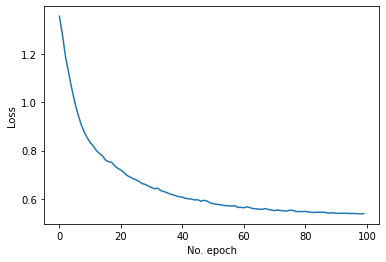

In [ ]:
plt.plot(model.history.history['loss'])
plt.xlabel('No. epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print("Example of generated sequences")
TestUtils.generate(model, settings['alphabet_size'], 10, 20)

Example of generated sequences


<tf.Tensor: shape=(10, 21), dtype=int64, numpy=
array([[0, 1, 1, 1, 1, 1, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 2, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 2, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 2, 3, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [ ]:
exprs = TestUtils.generate(model, settings['alphabet_size'], num_samples=100, max_length=100, temperature=1.0)
exprs = TestUtils.clean_exprs(exprs.numpy())

ill_formed = []
for expr in exprs:
  if not settings['machine'].parse(expr, stop_symbol=0):
    ill_formed.append(expr)
print(f"Well formed expressions: {len(exprs)-len(ill_formed)}/{len(exprs)}")

num_uniques = np.unique(exprs, axis=0).shape[0]
print(f"Unique expressions: {num_uniques}/{len(exprs)}")

Well formed expressions: 93/100
Unique expressions: 84/100


# Random ideas

- Try a net architecture involving a "fixer", for example:
 - LSTM A generates an expression
 - LSTM B reads the generated expression and then outputs a new "fixed" expression
   based on the input.
 - The idea here is that B has a global view of the expression read and needs only focus on localized actions. So in theory it would be a much easier job.
 - There can be multiple iterations of B
- Try reinforcement learning
- GAN
